In [10]:
import sys
import time
import os
import stim
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pymatching
import subprocess
from IPython.display import SVG, display

# import chromobius

sys.path.insert(0, os.path.abspath('/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/stabilizer/src'))

import surface_code as sc
import noise_util as ns
import tomography_util as tm
importlib.reload(sc)
importlib.reload(ns)
importlib.reload(tm)

<module 'tomography_util' from '/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/stabilizer/src/tomography_util.py'>

In [11]:
# Experiment Parameters
SHOTS = 1000
BASE_ERROR = 0.001
DISTANCES = np.array([3, 5, 7, 9, 11, 13])
T1 = 10 ** -4
T2 = 10 ** -4
tau = np.array([2.5*10**-6, 4*10**-6, 6*10**-6, 8*10**-6, 10**-5, 2.2*10**-5])
lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
compile_command = [
    "/opt/homebrew/bin/mpicxx",  # use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-DMPI_ENABLED",
    "-o",
    "noisy_code_sim",
    "noisy_code_sim.cpp"
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.
Compilation successful.


In [12]:
def run_single_distance_experiment(distance, tau_values, shots, base_error, T1, T2):
    """
    For a single code distance, sweep over tau_values and compute LERs for both Stim and C++ pipelines.
    Returns two lists [LER(tau_i)] for Stim and C++ aligned with tau_values.
    """
    print(f"\n=== Distance = {distance} ===")

    # Pre-create base circuit (structure doesn't depend on tau)
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=distance,
        distance=distance
    )

    # Ensure output folder exists
    out_dir = "./surface_code_qasm"
    os.makedirs(out_dir, exist_ok=True)

    stim_ler_list = []
    cpp_ler_list = []

    lam = 1 / T2 - 1 / (2 * T1)

    for tau_i in tau_values:
        # Per-tau noise parameters
        p_amp_i = 1 - np.exp(-tau_i / T1)
        p_phase_i = 1 - np.exp(-lam * tau_i)

        # 1) Build noise model and noisy circuit for this tau
        model = ns.ErrorModel(circuit)
        model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
        model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
        model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
        model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp_i/4}, {p_amp_i/4}, {p_amp_i/4 + p_phase_i/2})')
        model.setting_error('Reset', True, f'PAULI_CHANNEL_1({p_amp_i/4}, {p_amp_i/4}, {p_amp_i/4 + p_phase_i/2})')
        stim_circuit = model.generate_noisy_circuit()

        # 2) Stim simulation
        stim_sampler = stim_circuit.compile_detector_sampler()
        start_time = time.perf_counter()
        stim_det_samples, stim_obs_flips = stim_sampler.sample(shots, separate_observables=True, bit_packed=False)
        stim_time = time.perf_counter() - start_time

        dem = stim_circuit.detector_error_model(decompose_errors=True)
        matching = pymatching.Matching.from_detector_error_model(dem)

        stim_errors = 0
        stim_post_selected = 0
        for i in range(shots):
            # Optionally add post-selection rule here
            stim_post_selected += 1
            prediction = matching.decode(stim_det_samples[i])
            if prediction[0] != stim_obs_flips[i][0]:
                stim_errors += 1
        stim_ler = stim_errors / stim_post_selected if stim_post_selected > 0 else 0.0
        stim_ler_list.append(stim_ler)
        print(f"tau/T1={tau_i/T1:.3f} | Stim LER: {stim_ler:.4e} (time {stim_time:.3f}s)")

        # 3) C++ simulation path for same tau
        stab_circuit = model.generate_noisy_circuit()
        qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
        qasm_output = ns.inject_amplitude_damp(qasm_output, model)

        qasm_file_path = os.path.join(out_dir, f"surface_code_d{distance}_tau{tau_i:.2e}.qasm")
        cpp_output_path = os.path.join(out_dir, f"measurements_d{distance}_tau{tau_i:.2e}.txt")
        with open(qasm_file_path, "w") as f:
            f.write(qasm_output)

        num_qubits = stab_circuit.num_qubits
        run_command = [
            "/opt/homebrew/bin/mpirun", "-np", str(os.cpu_count()),
            "./noisy_code_sim", str(num_qubits), str(shots), qasm_file_path, cpp_output_path
        ]
        result = subprocess.run(run_command, capture_output=True, text=True)

        cpp_time = 0.0
        for line in result.stdout.strip().split('\n'):
            if "Total C++ simulation time" in line:
                try:
                    cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                except (ValueError, IndexError):
                    pass

        cpp_ler = 0.0
        try:
            with open(cpp_output_path, "r") as f:
                measurement_strings = [line for line in f.read().strip().split('\n') if line]

            if measurement_strings:
                measurement_data = np.array([line.split() for line in measurement_strings], dtype=int).astype(bool)
                m2d_converter = stab_circuit.compile_m2d_converter()
                cpp_det_samples, cpp_obs_flips = m2d_converter.convert(measurements=measurement_data, separate_observables=True)

                cpp_errors = 0
                cpp_post_selected = 0
                for i in range(len(cpp_det_samples)):
                    cpp_post_selected += 1
                    prediction = matching.decode(cpp_det_samples[i])
                    if prediction[0] != cpp_obs_flips[i][0]:
                        cpp_errors += 1

                cpp_ler = cpp_errors / cpp_post_selected if cpp_post_selected > 0 else 0.0
        except FileNotFoundError:
            print("C++ output file not found. Skipping analysis.")

        cpp_ler_list.append(cpp_ler)
        # print(f"tau/T1={tau_i/T1:.3f} | C++  LER: {cpp_ler:.4e} (time {cpp_time:.3f}s)")

    return stim_ler_list, cpp_ler_list

# --- Sweep over distances and tau ---
stim_results = {}  # distance -> [LER(tau_i)]
cpp_results = {}

for d in DISTANCES:
    stim_lers, cpp_lers = run_single_distance_experiment(d, tau, SHOTS, BASE_ERROR, T1, T2)
    stim_results[d] = stim_lers
    cpp_results[d] = cpp_lers

print("\n=== Sweep Complete ===")
print({"stim": {int(k): v for k, v in stim_results.items()}})
print({"cpp": {int(k): v for k, v in cpp_results.items()}})


=== Distance = 3 ===
tau/T1=0.025 | Stim LER: 7.0000e-03 (time 0.000s)
tau/T1=0.025 | C++  LER: 4.0000e-03 (time 0.005s)
tau/T1=0.040 | Stim LER: 1.6000e-02 (time 0.000s)
tau/T1=0.025 | C++  LER: 4.0000e-03 (time 0.005s)
tau/T1=0.040 | Stim LER: 1.6000e-02 (time 0.000s)
tau/T1=0.040 | C++  LER: 9.0000e-03 (time 0.005s)
tau/T1=0.060 | Stim LER: 3.1000e-02 (time 0.000s)
tau/T1=0.040 | C++  LER: 9.0000e-03 (time 0.005s)
tau/T1=0.060 | Stim LER: 3.1000e-02 (time 0.000s)
tau/T1=0.060 | C++  LER: 2.5000e-02 (time 0.013s)
tau/T1=0.080 | Stim LER: 4.9000e-02 (time 0.000s)
tau/T1=0.060 | C++  LER: 2.5000e-02 (time 0.013s)
tau/T1=0.080 | Stim LER: 4.9000e-02 (time 0.000s)
tau/T1=0.080 | C++  LER: 4.2000e-02 (time 0.007s)
tau/T1=0.100 | Stim LER: 7.6000e-02 (time 0.000s)
tau/T1=0.080 | C++  LER: 4.2000e-02 (time 0.007s)
tau/T1=0.100 | Stim LER: 7.6000e-02 (time 0.000s)
tau/T1=0.100 | C++  LER: 6.8000e-02 (time 0.007s)
tau/T1=0.220 | Stim LER: 2.4400e-01 (time 0.000s)
tau/T1=0.100 | C++  LER: 6.8

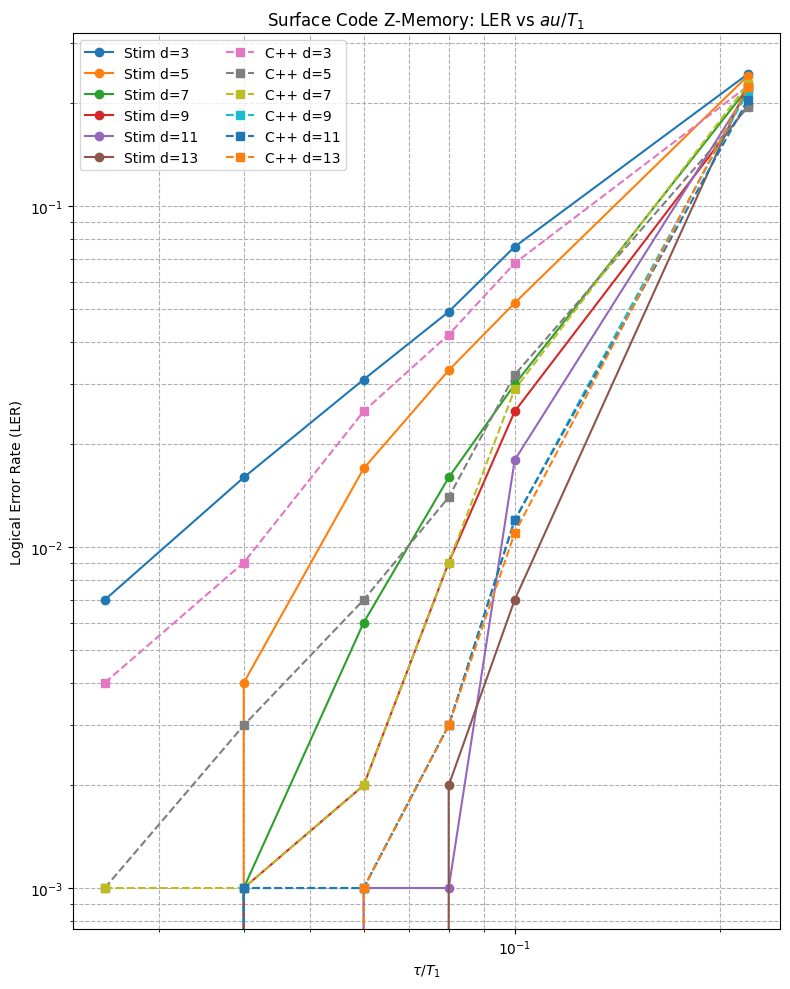

In [ ]:
# --- Plotting Results ---
import matplotlib.colors as mcolors
import colorsys

plt.figure(figsize=(8, 10))

x_vals = tau / T1

# Helpers to lighten/darken base colors
import numpy as np

def lighten(color, factor=0.6):
    # factor in (0,1]; smaller = lighter toward white; 0.6 is moderate
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    # factor in (0,1]; smaller = darker toward black; 0.8 is mild darken
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)

cmap = plt.get_cmap('tab10')

# Plot paired curves per distance using related colors
for i, d in enumerate(DISTANCES):
    base = cmap(i % cmap.N)
    stim_color = lighten(base, 0.6)
    cpp_color = darken(base, 0.8)

    plt.plot(
        x_vals, stim_results[d],
        marker='o', linestyle='-', linewidth=1.8, markersize=5,
        color=stim_color, label=f'Stim d={d}'
    )
    plt.plot(
        x_vals, cpp_results[d],
        marker='s', linestyle='--', linewidth=2.2, markersize=5,
        color=cpp_color, label=f'C++ d={d}'
    )

plt.xlabel(r"$\tau / T_1$")
plt.ylabel("Logical Error Rate (LER)")
plt.title("Surface Code Z-Memory: LER vs $\tau/T_1$")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()